In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import netCDF4
import numpy as np
import matplotlib
from unidecode import unidecode
import xarray as xr
%matplotlib inline



Read in all of the helper functions that we need

In [21]:
exec(open('/Users/weston/Desktop/Columbia/Research/Code/PyCode/general/helper_Functions/GADM_dict.py').read())
exec(open('/Users/weston/Desktop/Columbia/Research/Code/PyCode/project/Climate Modes - Yield Anoms/ENSOgroups.py').read())

Buttons and knobs

In [22]:
years = [1981,2011]


Read in all of the data from the SVD reconstructions of ENSO, TAV, IOD and NAO


In [23]:
## IOD ## 
iod = pd.DataFrame.from_csv('/Volumes/Data_Archive/Results/Climate Modes - Yield Anoms/country data/SVD/'+
                             'all crops1961_2012_Jan-DecENSOyr0har_iodSVD1_janSVD_allTrops.csv')  ## TAV ## 
iod.reset_index(inplace=True);
iod.set_index(['state','year'],inplace=True,drop=True)
iod.rename(columns={'SVD':'IOD'},inplace=True)
## TAV ## 
tav = pd.DataFrame.from_csv('/Volumes/Data_Archive/Results/Climate Modes - Yield Anoms/country data/SVD/'+
                             'all crops1961_2012_Jan-DecENSOyr0har_tavSVD2_janSVD_allTrops.csv')  
tav.reset_index(inplace=True);
tav.set_index(['state','year'],inplace=True,drop=True)
tav.rename(columns={'SVD':'TAV'},inplace=True)
###### ENSO ######
enso = pd.DataFrame.from_csv('/Volumes/Data_Archive/Results/Climate Modes - Yield Anoms/country data/SVD/'+
                             'all crops1961_2012_Jan-DecENSOyr0har_SVD2_janSVD_allTrops.csv')   
enso.reset_index(inplace=True);
enso.set_index(['state','year'],inplace=True,drop=True)
enso.rename(columns={'SVD':'ENSO'},inplace=True)
###### NAO ######
nao = pd.DataFrame.from_csv('/Volumes/Data_Archive/Results/Climate Modes - Yield Anoms/country data/SVD/'+
                             'DJFwheat1961_2012_Jan-DecENSOyr0har_naoSVD1_janSVD.csv')   
nao.reset_index(inplace=True);
nao.set_index(['state','year'],inplace=True,drop=True)
nao.rename(columns={'SVD':'NAO'},inplace=True)

crDF = pd.concat([enso,nao['NAO'],iod['IOD'],tav['TAV']],axis=1)
crDF.reset_index(inplace=True);
crDF = crDF[(crDF.year>=years[0])&(crDF.year<=years[1])]
#crDF.set_index(['state','year'],inplace=True,drop=True)


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  app.launch_new_instance()
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: from_csv is dep

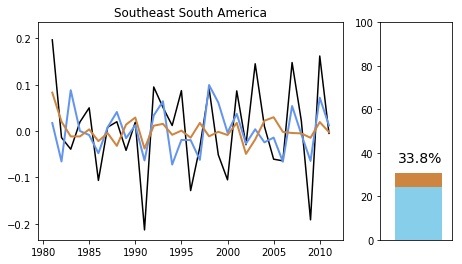

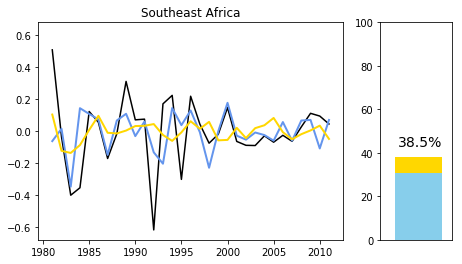

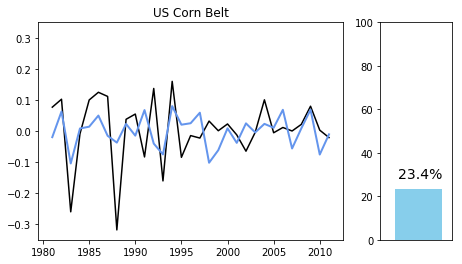

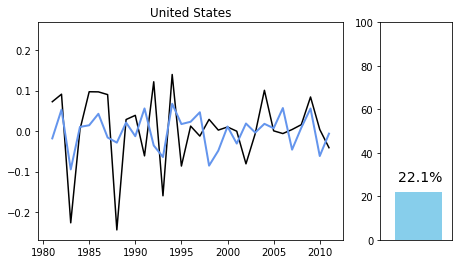

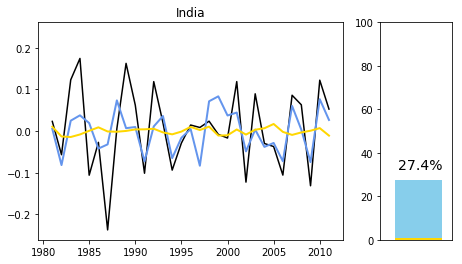

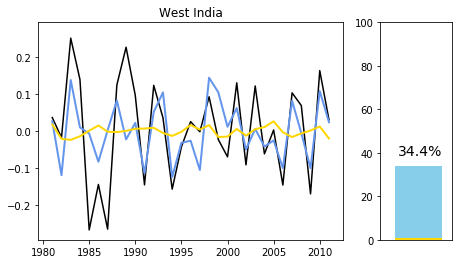

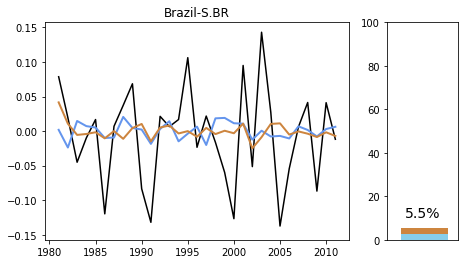

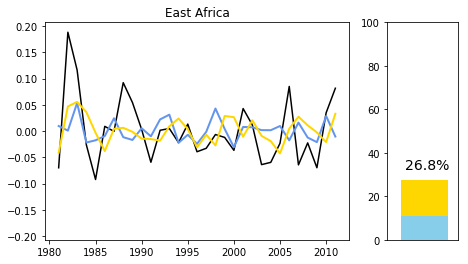

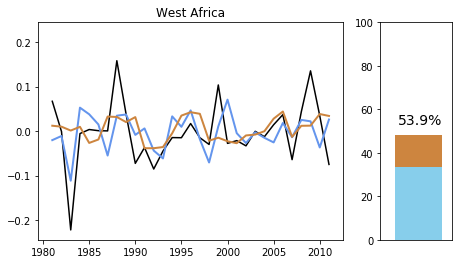

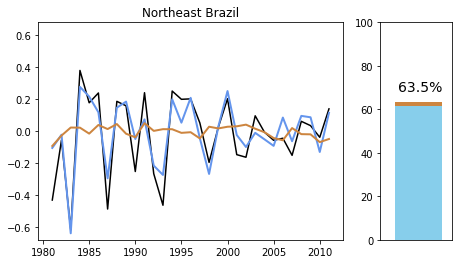

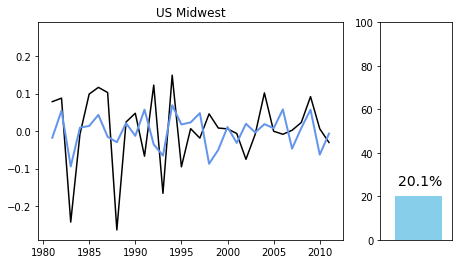

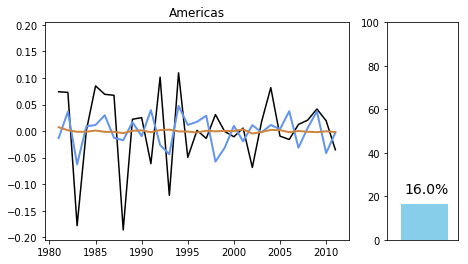

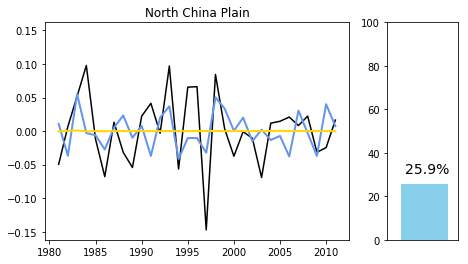

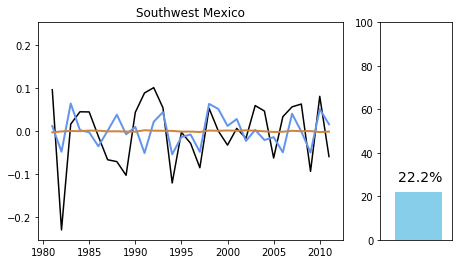

In [24]:
i=0
for regName in mRegions:
    mRegs = ['maize_'+x.upper () for x in mRegions[regName]]
    reg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)]
    reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
    reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
    reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
    reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
    reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
    reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
    reg.set_index('year',drop=True,inplace=True)
    
    regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
    ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

    if i==0:
        ts = np.zeros([regYld.values.shape[0],len(mRegions)])
        ts[:,i] = regYld.values
        i=i+1
    else:
        ts[:,i] = regYld.values
        i=i+1
    
    eVar2 = 100*(np.linalg.norm(ensoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    nVar2 = 100*(np.linalg.norm(naoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    iVar2 = 100*(np.linalg.norm(iodYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    tVar2 = 100*(np.linalg.norm(tavYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)

    eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
    nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
    iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
    tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
    enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
    yLim = regYld.abs().max()*1.1

    nB =0
    pB =0
    fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
    if eVar>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
    else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
    if nVar>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
    else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
    if iVar>0:b2 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
    else:b2 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
    if tVar>0:b2 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
    else:b2 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
    ax1.plot(regYld.sort_index(),'k',lw=1.5);
    ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
    ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
    ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
    ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
    #ax2.text(0.67,100-7,str("NAO:   "+str(np.round(nVar2,1))+"%"))
    #ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
    #ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
    #ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
    ax2.text(0.79,pB+5,str(str(np.round(enitVar2,1))+"%"),fontsize=14)
    ax1.set_ylim(-yLim,yLim)
    ax2.set_xlim(.6,1.35)
    ax2.set_xticks([])
    ax2.set_ylim(0,100)
    ax2.set_xlabel('')
    ax1.set_title(regName)
    #ax2.legend()
    fig.set_size_inches(12,4);
    plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/maize yield_'+regName+'_notxt_500nao.png')
    #plt.close()
    
    

0:Southeast South America
1:Southeast Africa
2:US Corn Belt
3:United States
4:India
5:West India
6:Brazil-S.BR
7:East Africa
8:West Africa
9:Northeast Brazil
10:US Midwest
11:Americas
12:North China Plain
13:Southwest Mexico


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


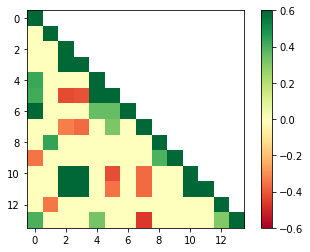

In [25]:
mCorMat = np.zeros([len(mRegions),len(mRegions)])*np.nan

for i in range(ts.shape[1]):
    for j in range(i,ts.shape[1]):
        mCorMat[j,i]=np.corrcoef(ts[:,i],ts[:,j])[0][1]
mCorMat[np.abs(mCorMat)<.296]=0
plt.imshow(mCorMat,vmin=-0.6,vmax=0.6,cmap='RdYlGn');plt.colorbar()
mRegNams = list(mRegions.keys())

i=0
for i in range(len(mRegNams)):
    print(str(i)+':'+mRegNams[i])

In [26]:

#for i in range(len(mRegions)):
#    for j in range(i,len(mRegions)):
        #print(mRegNams[j]+'  and  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:,j],ts[:,i])[0][1]))
        #print(mRegNams[i]+'  leads  '+mRegNams[j]+': '+np.str(np.corrcoef(ts[:-1,i],ts[1:,j])[0][1]))
        #print(mRegNams[j]+'  leads  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:-1,j],ts[1:,i])[0][1]))
        #print("\n")

In [27]:
tVar

0.005417793131239135

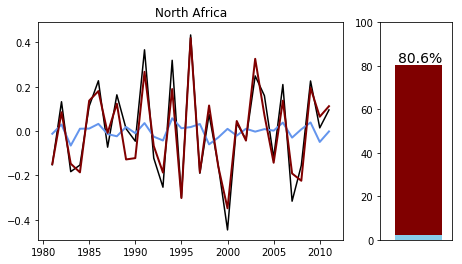

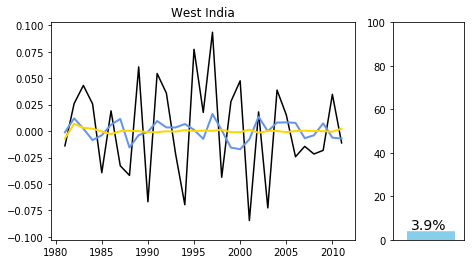

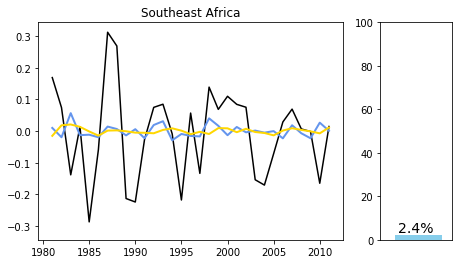

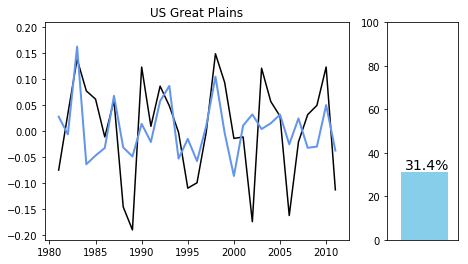

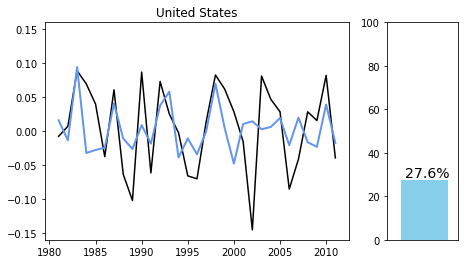

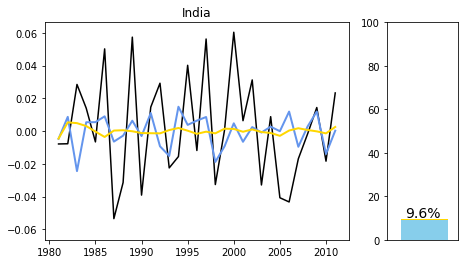

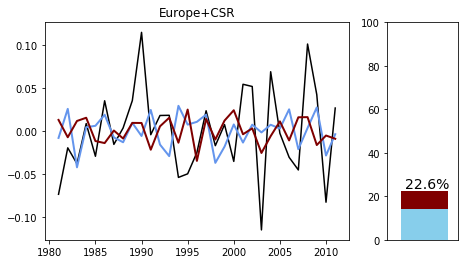

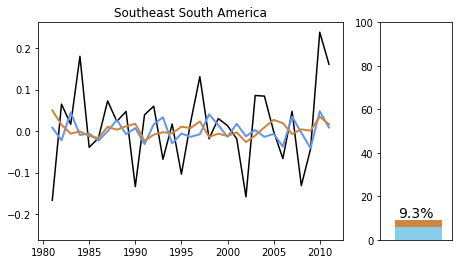

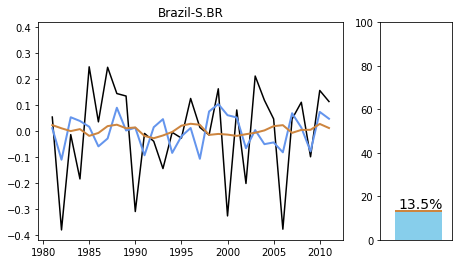

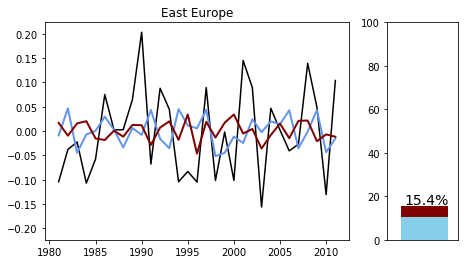

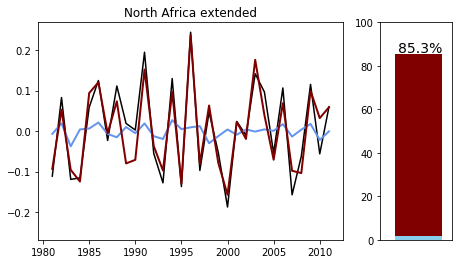

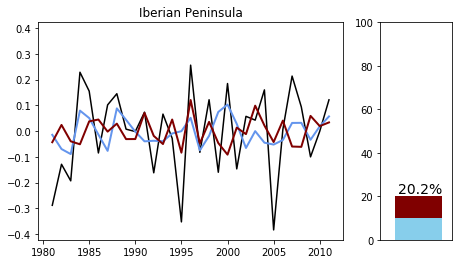

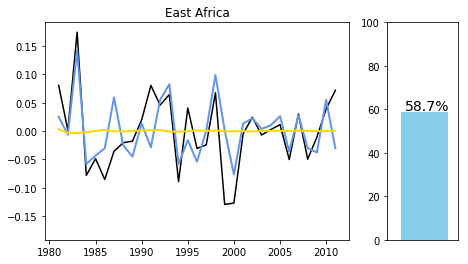

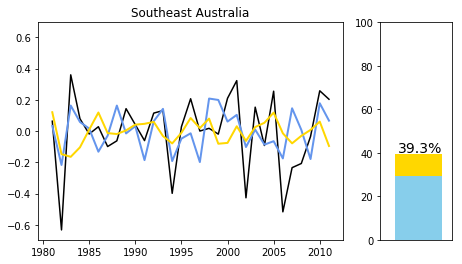

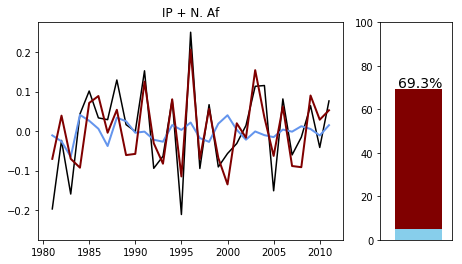

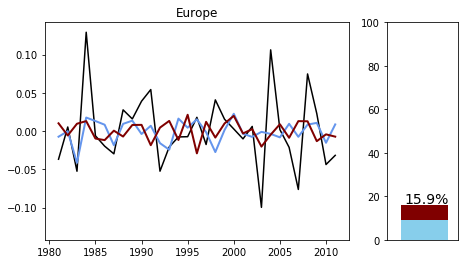

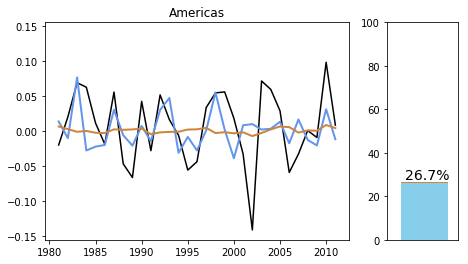

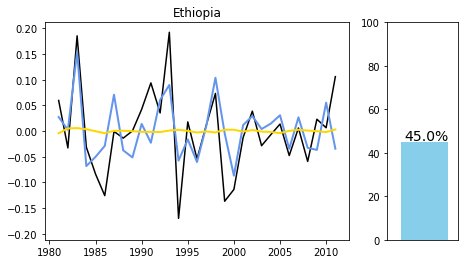

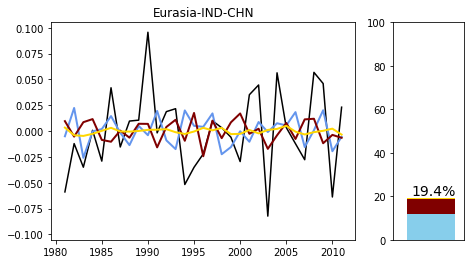

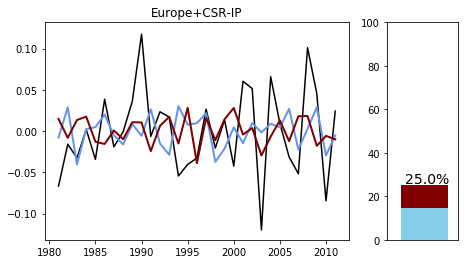

In [28]:
i=0
for regName in wRegions:
    wRegs = ['wheat_'+x.upper () for x in wRegions[regName]]
    reg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(wRegs)]
    reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
    reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
    reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
    reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
    reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
    reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
    reg.set_index('year',drop=True,inplace=True)
    
    regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
    ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

    
    if i==0:
        ts = np.zeros([regYld.values.shape[0],len(wRegions)])
        ts[:,i] = regYld.values
        i=i+1
    else:
        ts[:,i] = regYld.values
        i=i+1
    
    eVar2 = 100*(np.linalg.norm(ensoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    nVar2 = 100*(np.linalg.norm(naoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    iVar2 = 100*(np.linalg.norm(iodYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    tVar2 = 100*(np.linalg.norm(tavYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)

    eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
    nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
    iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
    tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
    enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
    yLim = regYld.abs().max()*1.1

    nB =0
    pB =0
    fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
    if eVar2>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
    else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
    if nVar2>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
    else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
    if iVar2>0:b3 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
    else:b3 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
    if tVar2>0:b4 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
    else:b4 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
    ax1.plot(regYld.sort_index(),'k',lw=1.5);
    ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
    ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
    ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
    ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
    #ax2.text(0.67,100-7,str("NAO:   "+str(np.round(nVar2,1))+"%"))
    #ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
    #ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
    #ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
    ax2.text(0.79,pB+1,str(str(np.round(pB,1))+"%"),fontsize=14)
    ax1.set_ylim(-yLim,yLim)
    ax2.set_xlim(.6,1.35)
    ax2.set_xticks([])
    ax2.set_ylim(0,100)
    ax2.set_xlabel('')
    #ax2.legend()
    ax1.set_title(regName)
    fig.set_size_inches(12,4);
    plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/wheat yield_'+regName+'_notxt_500nao.png')


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


0:North Africa
1:West India
2:Southeast Africa
3:US Great Plains
4:United States
5:India
6:Europe+CSR
7:Southeast South America
8:Brazil-S.BR
9:East Europe
10:North Africa extended
11:Iberian Peninsula
12:East Africa
13:Southeast Australia
14:IP + N. Af
15:Europe
16:Americas
17:Ethiopia
18:Eurasia-IND-CHN
19:Europe+CSR-IP


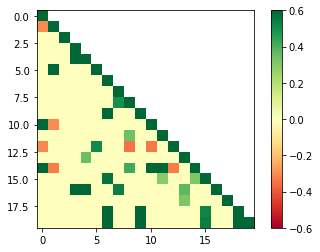

In [29]:
mCorMat = np.zeros([len(wRegions),len(wRegions)])*np.nan

for i in range(ts.shape[1]):
    for j in range(i,ts.shape[1]):
        mCorMat[j,i]=np.corrcoef(ts[:,i],ts[:,j])[0][1]
mCorMat[np.abs(mCorMat)<.296]=0
plt.imshow(mCorMat,vmin=-0.6,vmax=0.6,cmap='RdYlGn');plt.colorbar()
mRegNams = list(wRegions.keys())

#for i in range(len(wRegions)):
#    for j in range(i,len(wRegions)):
#        print(mRegNams[j]+'  and  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:,j],ts[:,i])[0][1]))
#        print(mRegNams[i]+'  leads  '+mRegNams[j]+': '+np.str(np.corrcoef(ts[:-1,i],ts[1:,j])[0][1]))
#        print(mRegNams[j]+'  leads  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:-1,j],ts[1:,i])[0][1]))
#        print("\n")

i=0
for i in range(len(mRegNams)):
    print(str(i)+':'+mRegNams[i])


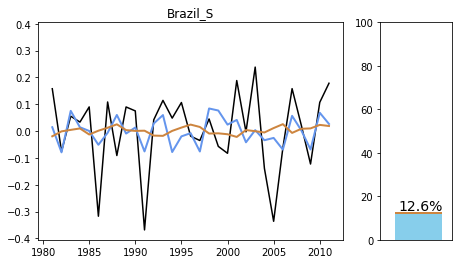

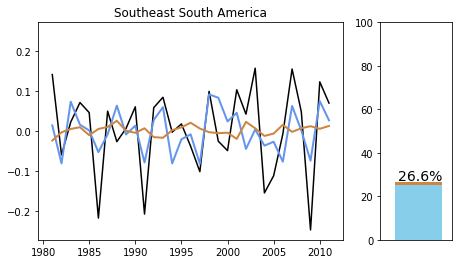

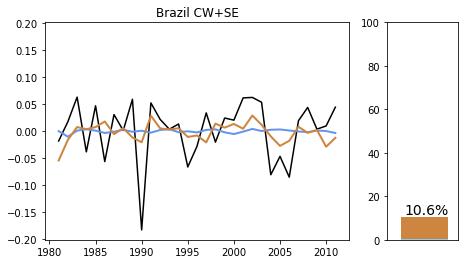

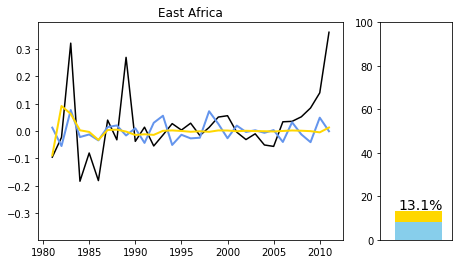

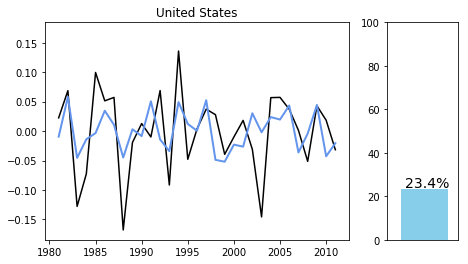

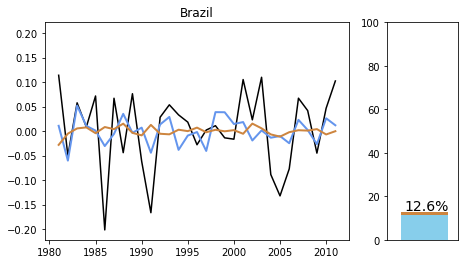

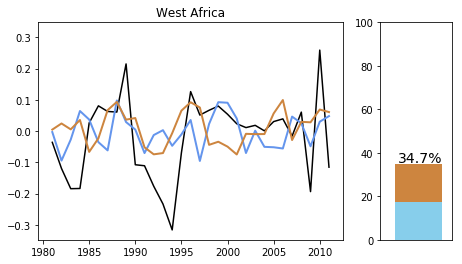

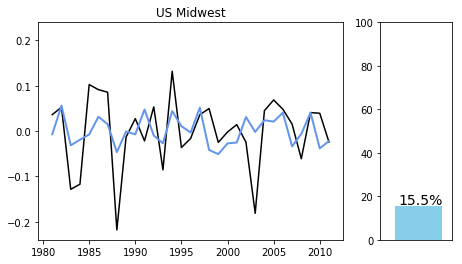

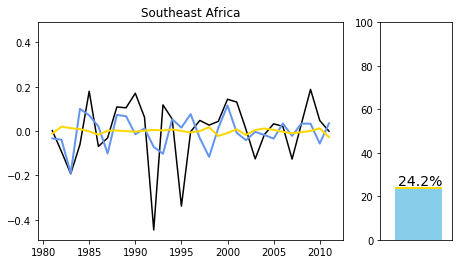

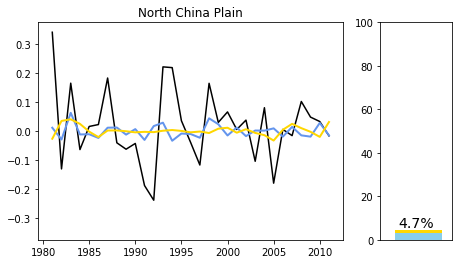

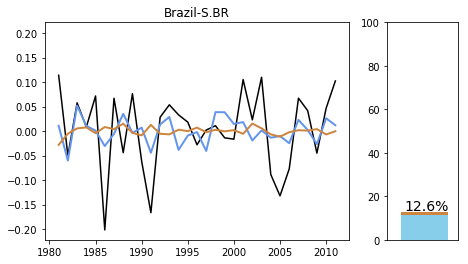

In [30]:
i=0
for regName in sRegions:
    sRegs = ['soy_'+x.upper () for x in sRegions[regName]]
    reg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(sRegs)]
    reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
    reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
    reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
    reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
    reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
    reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
    reg.set_index('year',drop=True,inplace=True)
    
    regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
    ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
    enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
    enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
              reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

    eVar2 = 100*(np.linalg.norm(ensoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    nVar2 = 100*(np.linalg.norm(naoYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    iVar2 = 100*(np.linalg.norm(iodYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    tVar2 = 100*(np.linalg.norm(tavYld.fillna(0).values)**2/np.linalg.norm(regYld.values)**2)
    enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)

    eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
    nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
    iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
    tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
    enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
    yLim = regYld.abs().max()*1.1

    if i==0:
        ts = np.zeros([regYld.values.shape[0],len(sRegions)])
        ts[:,i] = regYld.values
        i=i+1
    else:
        ts[:,i] = regYld.values
        i=i+1
    
    nB =0
    pB =0
    fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
    if eVar2>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
    else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
    if nVar2>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
    else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
    if iVar2>0:b3 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
    else:b3 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
    if tVar2>0:b4 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
    else:b4 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
    ax1.plot(regYld.sort_index(),'k',lw=1.5);
    ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
    ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
    ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
    ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
    #ax2.text(0.67,100-7,str("NAO:   "+str(np.round(nVar2,1))+"%"))
    #ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
    #ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
    #ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
    ax2.text(0.79,pB+1,str(str(np.round(pB,1))+"%"),fontsize=14)
    ax1.set_ylim(-yLim,yLim)
    ax2.set_xlim(.6,1.35)
    ax2.set_xticks([])
    ax2.set_ylim(0,100)
    ax2.set_xlabel('')
    ax1.set_title(regName)
    #ax2.legend()
    fig.set_size_inches(12,4);
    plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/soy yield_'+regName+'_notxt_500nao.png')


0:Brazil_S
1:Southeast South America
2:Brazil CW+SE
3:East Africa
4:United States
5:Brazil
6:West Africa
7:US Midwest
8:Southeast Africa
9:North China Plain
10:Brazil-S.BR


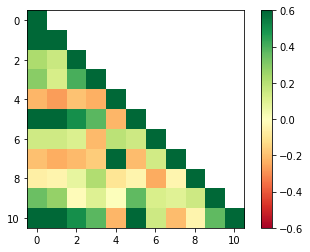

In [31]:
mCorMat = np.zeros([len(sRegions),len(sRegions)])*np.nan

for i in range(ts.shape[1]):
    for j in range(i,ts.shape[1]):
        mCorMat[j,i]=np.corrcoef(ts[:,i],ts[:,j])[0][1]
#mCorMat[np.abs(mCorMat)<.296]=0
plt.imshow(mCorMat,vmin=-0.6,vmax=0.6,cmap='RdYlGn');plt.colorbar()
mRegNams = list(sRegions.keys())

#for i in range(len(sRegions)):
#    for j in range(i,len(sRegions)):
#        print(mRegNams[j]+'  and  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:,j],ts[:,i])[0][1]))
#        print(mRegNams[i]+'  leads  '+mRegNams[j]+': '+np.str(np.corrcoef(ts[:-1,i],ts[1:,j])[0][1]))
#        print(mRegNams[j]+'  leads  '+mRegNams[i]+': '+np.str(np.corrcoef(ts[:-1,j],ts[1:,i])[0][1]))
#        print("\n")
        
i=0
for i in range(len(mRegNams)):
    print(str(i)+':'+mRegNams[i])


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Full TS (relative): 13.521304292930468
ENSO removed (relative): 10.503693958438468

Full TS (000 Tonnes): 1.3521304292930468e-06
ENSO removed (000 Tonnes): 1.0503693958438464e-06
Fraction of the 1983 yield anomaly: 50.7665684335



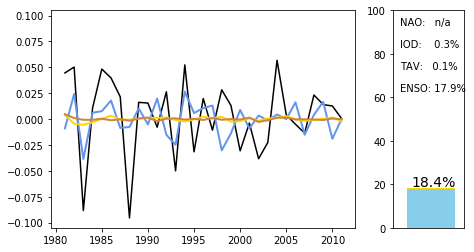

In [32]:
mRegs = [x for x in crDF.state.unique() if x[0:5]=='maize']
usStates = ['maize_'+x.upper () for x in mRegions['Americas']]

USreg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['South Africa','Brazil','Mozambique','Zimbabwe','United States'])]
US2reg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['Mexico','India','Argentina','China'])]
#USreg = crDF[['Harvested_Area','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(usStates)]
USreg['ensoProd']=USreg['Harvested_Area']*USreg['ENSO']*USreg['expectedYldGau']
USreg.set_index('year',drop=True,inplace=True)
US2reg['ensoProd']=US2reg['Harvested_Area']*US2reg['ENSO']*US2reg['expectedYldGau']
US2reg.set_index('year',drop=True,inplace=True)


reg = crDF[['Harvested_Area','expectedYldGau','yield','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)]
reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
reg.set_index('year',drop=True,inplace=True)

regYldExp = reg['expectedProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
USensoYld =USreg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
US2ensoYld =US2reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

eVar2 = 100*(np.linalg.norm(ensoYld.values)**2/np.linalg.norm(regYld.values)**2)
nVar2 = 100*(np.linalg.norm(naoYld.values)**2/np.linalg.norm(regYld.values)**2)
iVar2 = 100*(np.linalg.norm(iodYld.values)**2/np.linalg.norm(regYld.values)**2)
tVar2 = 100*(np.linalg.norm(tavYld.values)**2/np.linalg.norm(regYld.values)**2)
enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)

eVarUS2 = 100*(np.linalg.norm(USensoYld.values)**2/np.linalg.norm(regYld.values)**2)
eVarUS = 100*(np.linalg.norm(US2ensoYld.values)**2/np.linalg.norm(regYld.values)**2)

eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
yLim = regYld.abs().max()*1.1

nB =0
pB =0
fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
if eVar2>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
if nVar2>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
if iVar2>0:b3 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
else:b3 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
if tVar2>0:b4 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
else:b4 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
ax1.plot(regYld.sort_index(),'k',lw=1.5);
ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
ax2.text(0.67,100-7,str("NAO:   n/a"))
ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
ax2.text(0.79,pB+1,str(str(np.round(pB,1))+"%"),fontsize=14)
ax1.set_ylim(-yLim,yLim)
ax2.set_xlim(.6,1.35)
ax2.set_xticks([])
ax2.set_ylim(0,100)
ax2.set_xlabel('')
#ax2.legend()
fig.set_size_inches(12,4);


plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/maize yield_global_500nao.png')

print('Full TS (relative): '+str(np.var(regYld*100)))
print('ENSO removed (relative): '+str(np.var((regYld-enitYld)*100))+'\n')
print('Full TS (000 Tonnes): '+str(np.var(regYld*regYldExp)/1000))
print('ENSO removed (000 Tonnes): '+str(np.var(((regYld-enitYld)*regYldExp))/1000))
print('Fraction of the 1983 yield anomaly: '+str((enitYld.loc[1983]/regYld.loc[1983])*100)+'\n')


In [33]:
print('year   ENSO     Obs')
for iy in range(ensoYld.size):
    print(str(ensoYld.index[iy])+'   '+
          str(round(ensoYld.values[iy],3))+'   '+
          str(round(regYld.values[iy],3)))

year   ENSO     Obs
1981   -0.009   0.045
1982   0.024   0.05
1983   -0.039   -0.088
1984   0.006   0.011
1985   0.008   0.048
1986   0.018   0.04
1987   -0.009   0.022
1988   -0.008   -0.096
1989   0.01   0.016
1990   -0.005   0.015
1991   0.02   -0.008
1992   -0.015   0.026
1993   -0.025   -0.05
1994   0.026   0.052
1995   0.006   -0.032
1996   0.011   0.02
1997   0.013   -0.011
1998   -0.03   0.028
1999   -0.014   0.013
2000   0.009   -0.031
2001   -0.009   -0.004
2002   0.003   -0.038
2003   -0.001   -0.023
2004   0.004   0.057
2005   -0.0   0.004
2006   0.016   -0.005
2007   -0.015   -0.014
2008   0.004   0.023
2009   0.017   0.014
2010   -0.019   0.013
2011   0.0   0.0


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Full TS (relative): 6.093502004494484
ENSO removed (relative): 6.188949330286495

Full TS (000 Tonnes): 6.093502004494486e-07
ENSO removed (000 Tonnes): 6.188949330286496e-07


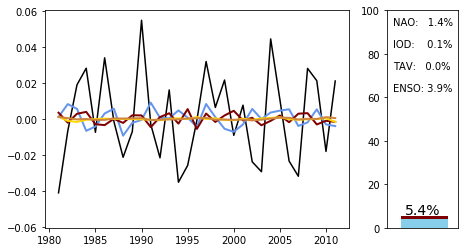

In [34]:
mRegs = [x for x in crDF.state.unique() if x[0:5]=='wheat']
#usStates = ['wheat_'+x.upper () for x in wRegions['Americas']]

CNTreg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['Argentina','Uruguay','Brazil','Australia','United States'])]
#CNTreg = crDF[['Harvested_Area','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(usStates)]
CNT2reg = crDF[['Harvested_Area','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['India','Spain','Portugal','France','Germany','United Kingdom','China','Afghanistan','Iran',
'Sweden','Denmark','Norway','Turkey','Romania','Syria','Pakistan','Iraq','Yugoslavia','Czechoslovakia','Belgium-Luxembourg','USSR'])]

CNTreg['ensoProd']=CNTreg['Harvested_Area']*CNTreg['ENSO']*CNTreg['expectedYldGau']
CNTreg.set_index('year',drop=True,inplace=True)
CNT2reg['ensoProd']=CNT2reg['Harvested_Area']*CNT2reg['ENSO']*CNT2reg['expectedYldGau']
CNT2reg.set_index('year',drop=True,inplace=True)

reg = crDF[['Harvested_Area','expectedYldGau','yield','yldAnomGau','ENSO','NAO','IOD','TAV','year','state']][crDF['state'].isin(mRegs)]
reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
reg.set_index('year',drop=True,inplace=True)

CNTensoYld =CNTreg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
CNT2ensoYld =CNT2reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
regYldExp = reg['expectedProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

eVarCNT2 = 100*(np.linalg.norm(CNTensoYld.values)**2/np.linalg.norm(regYld.values)**2)
eVarCNT = 100*(np.linalg.norm(CNT2ensoYld.values)**2/np.linalg.norm(regYld.values)**2)

eVar2 = 100*(np.linalg.norm(ensoYld.values)**2/np.linalg.norm(regYld.values)**2)
nVar2 = 100*(np.linalg.norm(naoYld.values)**2/np.linalg.norm(regYld.values)**2)
iVar2 = 100*(np.linalg.norm(iodYld.values)**2/np.linalg.norm(regYld.values)**2)
tVar2 = 100*(np.linalg.norm(tavYld.values)**2/np.linalg.norm(regYld.values)**2)
enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)


eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
yLim = regYld.abs().max()*1.1

nB =0
pB =0
fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
if eVar2>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
if nVar2>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
if iVar2>0:b3 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
else:b3 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
if tVar2>0:b4 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
else:b4 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
ax1.plot(regYld.sort_index(),'k',lw=1.5);
ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
ax2.text(0.67,100-7,str("NAO:   "+str(np.round(nVar2,1))+"%"))
ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
ax2.text(0.79,pB+1,str(str(np.round(pB,1))+"%"),fontsize=14)
ax1.set_ylim(-yLim,yLim)
ax2.set_xlim(.6,1.35)
ax2.set_xticks([])
ax2.set_ylim(0,100)
ax2.set_xlabel('')
#ax2.legend()
fig.set_size_inches(12,4);

plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/wheat yield_global_500nao.png')

print('Full TS (relative): '+str(np.var(regYld*100)))
print('ENSO removed (relative): '+str(np.var((regYld-enitYld)*100))+'\n')
print('Full TS (000 Tonnes): '+str(np.var(regYld*regYldExp)/1000))
print('ENSO removed (000 Tonnes): '+str(np.var(((regYld-enitYld)*regYldExp))/1000))

In [35]:
#Lets look into how much ENSO accounts for the worst Soy and Wheat years
print('year   ENSO     Obs')
for iy in range(ensoYld.size):
    print(str(ensoYld.index[iy])+'   '+
          str(round(ensoYld.values[iy],3))+'   '+
          str(round(regYld.values[iy],3)))

year   ENSO     Obs
1981   0.001   -0.041
1982   0.008   -0.007
1983   0.006   0.019
1984   -0.007   0.028
1985   -0.004   -0.007
1986   0.003   0.034
1987   0.006   -0.001
1988   -0.009   -0.021
1989   -0.002   -0.007
1990   -0.001   0.055
1991   0.009   -0.003
1992   0.001   -0.021
1993   0.0   0.016
1994   0.005   -0.035
1995   0.001   -0.026
1996   -0.004   -0.001
1997   0.008   0.032
1998   0.001   0.006
1999   -0.005   0.022
2000   -0.007   -0.009
2001   -0.003   0.008
2002   0.006   -0.024
2003   0.0   -0.029
2004   0.004   0.044
2005   0.005   0.011
2006   0.005   -0.023
2007   -0.004   -0.032
2008   -0.002   0.028
2009   0.005   0.021
2010   -0.003   -0.018
2011   -0.004   0.021


/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/weston/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Full TS (relative): 14.960741155220303
ENSO removed (relative): 14.184360697887868

Full TS (000 Tonnes): 1.49607411552203e-06
ENSO removed (000 Tonnes): 1.4184360697887862e-06


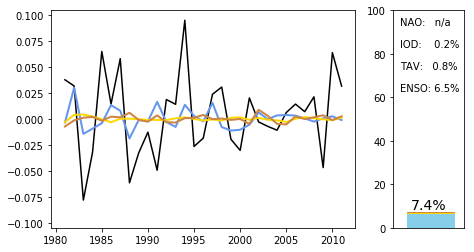

In [36]:
mRegs = [x for x in crDF.state.unique() if x[0:3]=='soy']

#usStates = ['wheat_'+x.upper () for x in wRegions['Eurasia']]

CNTreg = crDF[['Harvested_Area','yield','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['United States','South Africa','Zimbabwe'])]
CNT2reg = crDF[['Harvested_Area','yield','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(mRegs)][crDF['country.name'].isin(['Brazil','China','Argentina','India'])]
#CNT2reg = crDF[['Harvested_Area','yldAnomGau','ENSO','NAO','IOD','TAV','year']][crDF['state'].isin(usStates)]
CNTreg['ensoProd']=CNTreg['Harvested_Area']*CNTreg['ENSO']*CNTreg['expectedYldGau']
CNTreg.set_index('year',drop=True,inplace=True)
CNT2reg['ensoProd']=CNT2reg['Harvested_Area']*CNT2reg['ENSO']*CNT2reg['expectedYldGau']
CNT2reg.set_index('year',drop=True,inplace=True)

reg = crDF[['Harvested_Area','yield','expectedYldGau','yldAnomGau','ENSO','NAO','IOD','TAV','year','state']][crDF['state'].isin(mRegs)]
reg['expectedProd']=reg['Harvested_Area']*reg['expectedYldGau']
reg['ProdAnomGau']=reg['Harvested_Area']*reg['yldAnomGau']*reg['expectedYldGau']
reg['ensoProd']=reg['Harvested_Area']*reg['ENSO']*reg['expectedYldGau']
reg['naoProd']=reg['Harvested_Area']*reg['NAO']*reg['expectedYldGau']
reg['iodProd']=reg['Harvested_Area']*reg['IOD']*reg['expectedYldGau']
reg['tavProd']=reg['Harvested_Area']*reg['TAV']*reg['expectedYldGau']
reg.set_index('year',drop=True,inplace=True)

CNTensoYld =CNTreg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
CNT2ensoYld =CNT2reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')

regYldExp = reg['expectedProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
regYld = reg['ProdAnomGau'].sum(level='year')/reg['expectedProd'].sum(level='year')
ensoYld =reg['ensoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
naoYld =reg['naoProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
tavYld =reg['tavProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
iodYld =reg['iodProd'].sum(level='year')/reg['expectedProd'].sum(level='year')
enYld =(reg['naoProd'].sum(level='year').fillna(0)+reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
eniYld =(reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')
enitYld =(reg['tavProd'].sum(level='year').fillna(0)+reg['iodProd'].sum(level='year').fillna(0)+reg['naoProd'].sum(level='year').fillna(0)+
          reg['ensoProd'].sum(level='year').fillna(0))/reg['expectedProd'].sum(level='year')

eVar2 = 100*(np.linalg.norm(ensoYld.values)**2/np.linalg.norm(regYld.values)**2)
nVar2 = 100*(np.linalg.norm(naoYld.values)**2/np.linalg.norm(regYld.values)**2)
iVar2 = 100*(np.linalg.norm(iodYld.values)**2/np.linalg.norm(regYld.values)**2)
tVar2 = 100*(np.linalg.norm(tavYld.values)**2/np.linalg.norm(regYld.values)**2)
enitVar2 = 100*(np.linalg.norm(enitYld.values)**2/np.linalg.norm(regYld.values)**2)

eVarCNT2 = 100*(np.linalg.norm(CNTensoYld.values)**2/np.linalg.norm(regYld.values)**2)
eVarCNT = 100*(np.linalg.norm(CNT2ensoYld.values)**2/np.linalg.norm(regYld.values)**2)

eVar = 1-(np.var(regYld-ensoYld)/np.var(regYld))
nVar = 1-(np.var(regYld-naoYld)/np.var(regYld))
iVar = 1-(np.var(regYld-iodYld)/np.var(regYld))
tVar = 1-(np.var(regYld-tavYld)/np.var(regYld))
enitVar = 1-(np.var(regYld-enitYld)/np.var(regYld))
yLim = regYld.abs().max()*1.1

nB =0
pB =0
fig = plt.figure(); ax1 = plt.subplot(121); ax2 = plt.subplot(185)
if eVar2>=0:b1 = ax2.bar(1, eVar2, 0.5, bottom=pB,color='skyblue',label='ENSO');pB=pB+eVar2
else:b1 = ax2.bar(1, eVar2, 0.5, bottom=nB,color='skyblue',label='ENSO');nB=np.nansum([nB,eVar2]) 
if nVar2>0:b2 = ax2.bar(1, nVar2, 0.5, bottom=pB,color='maroon',label='NAO');pB=pB+nVar2
else:b2 = ax2.bar(1, nVar2, 0.5, bottom=nB,color='maroon',label='NAO');nB=np.nansum([nB,nVar2]) 
if iVar2>0:b3 = ax2.bar(1, iVar2, 0.5, bottom=pB,color='gold',label='IOD');pB=pB+iVar2
else:b3 = ax2.bar(1, iVar2, 0.5, bottom=nB,color='gold',label='IOD');nB=np.nansum([nB,iVar2]) 
if tVar2>0:b4 = ax2.bar(1, tVar2, 0.5, bottom=pB,color='peru',label='TAV');pB=pB+tVar2
else:b4 = ax2.bar(1, tVar2, 0.5, bottom=nB,color='peru',label='TAV');nB=np.nansum([nB,tVar2]) 
ax1.plot(regYld.sort_index(),'k',lw=1.5);
ax1.plot(ensoYld.sort_index(),'-',color='cornflowerblue',lw=2)
ax1.plot(naoYld.sort_index(),'-',color='maroon',lw=2)
ax1.plot(iodYld.sort_index(),'-',color='gold',lw=2)
ax1.plot(tavYld.sort_index(),'-',color='peru',lw=2)
ax2.text(0.67,100-7,str("NAO:   n/a"))
ax2.text(0.67,100-17,str("IOD:    "+str(np.round(iVar2,1))+"%"))
ax2.text(0.67,100-27,str("TAV:   "+str(np.round(tVar2,1))+"%"))
ax2.text(0.67,100-37,str("ENSO: "+str(np.round(eVar2,1))+"%"))
ax2.text(0.79,pB+1,str(str(np.round(pB,1))+"%"),fontsize=14)
ax1.set_ylim(-yLim,yLim)
ax2.set_xlim(.6,1.35)
ax2.set_xticks([])
ax2.set_ylim(0,100)
ax2.set_xlabel('')
#ax2.legend()
fig.set_size_inches(12,4);

plt.savefig('/Users/weston/Desktop/Columbia/Research/Results/Climate Modes - Yield Anoms/time series/soy yield_global_500nao.png')

print('Full TS (relative): '+str(np.var(regYld*100)))
print('ENSO removed (relative): '+str(np.var((regYld-enitYld)*100))+'\n')
print('Full TS (000 Tonnes): '+str(np.var(regYld*regYldExp)/1000))
print('ENSO removed (000 Tonnes): '+str(np.var(((regYld-enitYld)*regYldExp))/1000))

In [37]:
#Lets look into how much ENSO accounts for the worst Soy and Wheat years
print('year   ENSO     Obs')
for iy in range(ensoYld.size):
    print(str(ensoYld.index[iy])+'   '+
          str(round(ensoYld.values[iy],3))+'   '+
          str(round(regYld.values[iy],3)))

year   ENSO     Obs
1981   -0.003   0.038
1982   0.03   0.032
1983   -0.014   -0.078
1984   -0.009   -0.032
1985   -0.004   0.065
1986   0.013   0.014
1987   0.008   0.058
1988   -0.019   -0.061
1989   -0.001   -0.033
1990   -0.002   -0.013
1991   0.017   -0.049
1992   -0.003   0.019
1993   -0.008   0.014
1994   0.014   0.095
1995   0.003   -0.026
1996   -0.002   -0.018
1997   0.016   0.024
1998   -0.008   0.031
1999   -0.011   -0.019
2000   -0.01   -0.03
2001   -0.005   0.02
2002   0.006   -0.003
2003   -0.0   -0.007
2004   0.004   -0.011
2005   0.004   0.006
2006   0.003   0.014
2007   0.001   0.007
2008   -0.002   0.021
2009   0.001   -0.047
2010   0.003   0.064
2011   -0.001   0.032


In [38]:
ensoYld.index[0]

1981